# Segmentação de Imagens de Trânsito

O objetivo deste exercicio é desenvolver um modelo de segmentação de imagens.

O dataset utilizado é o [CamSeq01](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/), que possui apenas 101 imagens de alta resolução. Cada pixel é rotulado como uma de 32 classes (carro, pedestre, etc).

Existem apenas 71 imagens de treino e 30 de teste.

A métrica oficial é a DICE.

Dica de como calculá-la: https://stackoverflow.com/questions/31273652/how-to-calculate-dice-coefficient-for-measuring-accuracy-of-image-segmentation-i

# Importaçãão de Bibliotecas

In [2]:
! pip install neptune-client==0.9.1
! pip install pytorch_lightning==1.2.10

     |████████████████████████████████| 215kB 6.3MB/s 
     |████████████████████████████████| 829kB 7.6MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 174kB 12.4MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 133kB 13.3MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.1-py2.py3-none-any.whl size=371716 sha256=3db9c1254d332b8844f0da3cc9bca362e988bbe568b3e2d1487e46fba4400719
  Stored in directory: /root/.cache/pip/wheels/6e/d4/60/21005f18273566da0463587bed8c69cce7f300a404edf26df8
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=fafed0958c5718cb24ce742856c7dbd72274026472cee4bc3d2ab69a44111b1b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.

In [243]:
import torchvision
from torchvision import utils
from torchvision import transforms
import pandas as pd
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
import neptune.new as neptune

pytorch_lightning.utilities.seed.seed_everything(seed=123)

Global seed set to 123


123

### Download do Dataset

In [4]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/CamSeq01.zip .
!unzip CamSeq01.zip

Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/CamSeq01.zip...
\ [1/1 files][ 90.3 MiB/ 90.3 MiB] 100% Done                                    
Operation completed over 1 objects/90.3 MiB.                                     
Archive:  CamSeq01.zip
   creating: CamSeq01/
  inflating: CamSeq01/.DS_Store      
  inflating: __MACOSX/CamSeq01/._.DS_Store  
   creating: CamSeq01/test/
  inflating: CamSeq01/label_colors.txt  
   creating: CamSeq01/train/
  inflating: CamSeq01/readme.txt     
  inflating: CamSeq01/test/0016E5_08137.png  
  inflating: CamSeq01/test/0016E5_08123.png  
  inflating: CamSeq01/test/0016E5_08139_L.png  
  inflating: CamSeq01/test/0016E5_08095.png  
  inflating: CamSeq01/test/0016E5_08141_L.png  
  inflating: CamSeq01/test/0016E5_08143_L.png  
  inflating: CamSeq01/test/0016E5_08097.png  
  inflating: CamSeq01/test/0016E5_08135.png  
  inflating: CamSeq01/test/0016E5_08121.png  
  inflating: CamSeq01/test/0016E5_08109.png  
  inflating: CamSeq01/test/0

In [113]:
size_final = (256,256)
transforms_train = transforms.Compose([
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.Resize(size=size_final),
                                      
])

#Referência das Imagens

In [114]:
%cd /content/CamSeq01/train
files_train_all = !ls *_L.png
files_train = []
for i in files_train_all:
  files_train.append(i.split())
files_train = sum(files_train, [])
for i in range(len(files_train)):
  files_train[i] = files_train[i][:-6]

%cd /content/CamSeq01/test
files_test_all = !ls *_L.png
files_test = []
for i in files_test_all:
  files_test.append(i.split())
files_test = sum(files_test, [])
for i in range(len(files_test)):
  files_test[i] = files_test[i][:-6]
%cd /content

/content/CamSeq01/train
/content/CamSeq01/test
/content


In [115]:
files_test = files_test[:-3]

#Dicionário de Labels

In [116]:
labels = pd.read_csv('/content/CamSeq01/label_colors.txt',header=None)
colors_dic = {}

number = []
names = []
for i in labels[0]:
  colors_dic[str([int(x) for x in (i.split('\t')[0]).split(' ')])] = i.split('\t')[-1]
colors_dic

{'[0, 0, 0]': 'Void',
 '[0, 0, 192]': 'Sidewalk',
 '[0, 0, 64]': 'TrafficCone',
 '[0, 128, 192]': 'Bicyclist',
 '[0, 128, 64]': 'Bridge',
 '[0, 64, 64]': 'TrafficLight',
 '[128, 0, 0]': 'Building',
 '[128, 0, 192]': 'LaneMkgsDriv',
 '[128, 128, 0]': 'Tree',
 '[128, 128, 128]': 'Sky',
 '[128, 128, 192]': 'RoadShoulder',
 '[128, 128, 64]': 'Misc_Text',
 '[128, 64, 128]': 'Road',
 '[128, 64, 64]': 'OtherMoving',
 '[192, 0, 128]': 'Archway',
 '[192, 0, 192]': 'MotorcycleScooter',
 '[192, 0, 64]': 'LaneMkgsNonDriv',
 '[192, 128, 128]': 'SignSymbol',
 '[192, 128, 192]': 'Truck_Bus',
 '[192, 128, 64]': 'Child',
 '[192, 192, 0]': 'VegetationMisc',
 '[192, 192, 128]': 'Column_Pole',
 '[192, 64, 128]': 'Train',
 '[64, 0, 128]': 'Car',
 '[64, 0, 192]': 'CartLuggagePram',
 '[64, 0, 64]': 'Tunnel',
 '[64, 128, 192]': 'SUVPickupTruck',
 '[64, 128, 64]': 'Animal',
 '[64, 192, 0]': 'Wall',
 '[64, 192, 128]': 'ParkingBlock',
 '[64, 64, 0]': 'Pedestrian',
 '[64, 64, 128]': 'Fence'}

In [117]:
img_file_label = 'CamSeq01/train/0016E5_07959_L.png'
image_label_exemple = Image.open(img_file_label)
image_label_exemple = np.array(image_label_exemple)

labels_dict = {}
labels = np.arange(len(colors_dic.values()))
for i, k in enumerate(colors_dic):
    labels_dict[k] = labels[i]


print(labels_dict)

def pilToLabels(image_L):
  image_class = []
  image_label = []
  for i in range(image_L.shape[0]):
    for j in range(image_L.shape[1]):
      image_class.append(colors_dic['['+str(image_L[i,j][0])+', '+str(image_L[i,j][1])+', '+str(image_L[i,j][2])+']'])
      image_label.append(labels_dict['['+str(image_L[i,j][0])+', '+str(image_L[i,j][1])+', '+str(image_L[i,j][2])+']'])
  image_label = np.array(image_label)
  return image_class, image_label.reshape(image_L.shape[0],image_L.shape[1])

exemple_classes, exemple_labels = pilToLabels(image_label_exemple)
print(f'Tamanho do vetor de classes para a imagem: {len(exemple_classes)}')
print(f'Número de classes diferentes na imagem: {len(np.unique(exemple_classes))}')
print(f'Shape da matriz de labels que será usada na classificação: {exemple_labels.shape}')
print(f'Types image_label: {type(exemple_labels)}')

{'[64, 128, 64]': 0, '[192, 0, 128]': 1, '[0, 128, 192]': 2, '[0, 128, 64]': 3, '[128, 0, 0]': 4, '[64, 0, 128]': 5, '[64, 0, 192]': 6, '[192, 128, 64]': 7, '[192, 192, 128]': 8, '[64, 64, 128]': 9, '[128, 0, 192]': 10, '[192, 0, 64]': 11, '[128, 128, 64]': 12, '[192, 0, 192]': 13, '[128, 64, 64]': 14, '[64, 192, 128]': 15, '[64, 64, 0]': 16, '[128, 64, 128]': 17, '[128, 128, 192]': 18, '[0, 0, 192]': 19, '[192, 128, 128]': 20, '[128, 128, 128]': 21, '[64, 128, 192]': 22, '[0, 0, 64]': 23, '[0, 64, 64]': 24, '[192, 64, 128]': 25, '[128, 128, 0]': 26, '[192, 128, 192]': 27, '[64, 0, 64]': 28, '[192, 192, 0]': 29, '[0, 0, 0]': 30, '[64, 192, 0]': 31}


Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: I

Tamanho do vetor de classes para a imagem: 691200
Número de classes diferentes na imagem: 21
Shape da matriz de labels que será usada na classificação: (720, 960)
Types image_label: <class 'numpy.ndarray'>


In [118]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, files,stage):
        self.images = []
        self.labels = []
        for file in files:
            self.images.append(PIL.Image.open('CamSeq01/'+stage+'/'+file+ '.png'))
            _, label_final = pilToLabels(np.array(Image.open('CamSeq01/'+stage+'/'+file + '_L.png')))
            self.labels.append(label_final)            

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
        return transforms_train(self.images[idx]), transforms_train(self.labels[idx])

In [119]:
train_sub_data, val_sub_data = torch.utils.data.random_split(files_train, [50,16])

train_dataset = Dataset(train_sub_data,stage='train')
val_sub_data = Dataset(val_sub_data,stage='train')
test_data = Dataset(files_test,stage='test')

In [120]:
batch_size = 4
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True  )
batch_size = 4
val_dataloader = DataLoader(val_sub_data,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [121]:
input, target = next(iter(train_dataloader))

print(f'input = shape: {input.shape}')
print(f'input = min: {input.min()}; max: {input.max()}')
print(f'target = shape: {target.shape}')
print(f'target = min: {target.min()}; max: {target.max()}')

input = shape: torch.Size([4, 3, 256, 256])
input = min: 0.0; max: 1.0
target = shape: torch.Size([4, 1, 256, 256])
target = min: 1; max: 31


In [122]:
input_max = []
input_min = []
input_mean = []
output_values = []
for input, target in train_dataloader:
  input_min.append(input.min()) 
  input_max.append(input.max())
  input_mean.append(input.mean())
  values,count= np.unique(target, return_counts=True)

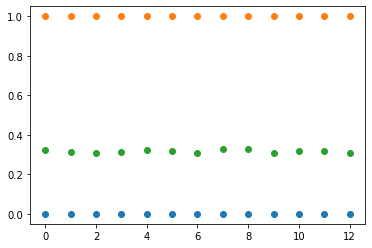

In [123]:
plt.figure()
plt.scatter(np.arange(len(input_min)) ,input_min)
plt.scatter(np.arange(len(input_max)) ,input_max)
plt.scatter(np.arange(len(input_mean)) ,input_mean)

(array([3., 3., 3., 3., 3., 3., 3., 3., 3., 4.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

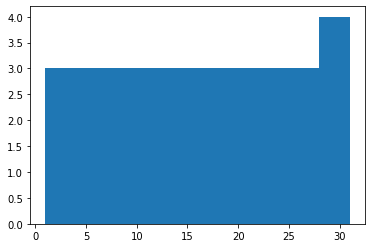

In [124]:
plt.hist(values)

In [241]:
# https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py

class DiceLoss(torch.nn.Module):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    print('Dice')
    def __init__(self, smooth = 1.):
      super(DiceLoss, self).__init__()
      self.smooth = smooth

    def forward(self, true, logits, eps=1e-7):
      num_classes = logits.shape[1]
      if num_classes == 1:
          true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
          true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
          true_1_hot_f = true_1_hot[:, 0:1, :, :]
          true_1_hot_s = true_1_hot[:, 1:2, :, :]
          true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
          pos_prob = torch.sigmoid(logits)
          neg_prob = 1 - pos_prob
          probas = torch.cat([pos_prob, neg_prob], dim=1)
      else:
          true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
          true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
          probas = F.softmax(logits, dim=1)
      true_1_hot = true_1_hot.type(logits.type())
      dims = (0,) + tuple(range(2, true.ndimension()))
      intersection = torch.sum(probas * true_1_hot, dims)
      cardinality = torch.sum(probas + true_1_hot, dims)
      dice_loss = (2. * intersection / (cardinality + eps)).mean()
      return (1 - dice_loss)

Dice


In [219]:
num_classes = len(colors_dic)
num_features = 64

In [238]:
class MyLightningModule(LightningModule):
    def __init__(self, hparams, run):
        super().__init__()

        print(hparams)
        self.hparams = hparams
        run['hparams'] = hparams  # Log to Neptune.
        print('log')
        self.criterion = DiceLoss()

        # Carregando um modelo baseado na MobileNet V3.
        self.model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=num_classes, init_features=num_features, pretrained=False)

    def forward(self, x):
        logits = self.model(x)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch

        # predict da rede
        logits = self.model(x)

        # calcula a perda
        batch_losses = self.criterion(y,logits)
        loss = batch_losses.mean()
        run['train/batch_loss'].log(loss)

        # O PL sempre espera um retorno nomeado 'loss' da training_step.
        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['train/loss'].log(avg_loss)
        return
  
    def validation_step(self, test_batch, batch_idx):
        x, y = test_batch

        # predict da rede
        logits, preds = self.forward(x)
        
        # calcula a perda
        batch_losses = self.criterion(y,logits)
                
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['valid/loss'].log(avg_loss)

        self.log('valid_loss', avg_loss.item(), prog_bar=True)
  
    def test_step(self, test_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = test_batch
        
        # predict da rede
        logits, preds = self.forward(x)
        
        # calcula a perda
        batch_losses = self.criterion(y,logits)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses}

    def test_epoch_end(self, outputs):
        # A implementação deste método é opcional no Pytorch Lightning.
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['valid/loss'].log(avg_loss)

        self.log('test_loss', avg_loss.item())

    def configure_optimizers(self):
        # Gradiente descendente
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams['learning_rate'])
        # Aqui usamos um scheduler dummy pois o pytorch lightning original requer um.
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 1.0)
        return [optimizer], [scheduler]  # Forma de retorno para associar um otimizador a um scheduler.

In [244]:
hparams = {
    'max_epochs': 50,
    'learning_rate': 3e-4,
    'pretrained': False,
    'augmentation': False
}
run = neptune.init(project='d230640/Aula8', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmZTg1OGU3Yi1jOWE1LTRjMjEtYTJjNS1hMjMwM2Y3NDRjOTUifQ==')
run["sys/tags"].add([f'pre:{hparams["pretrained"]}', f'aug:{hparams["augmentation"]}'])

pl_model = MyLightningModule(hparams=hparams, run=run)
trainer = Trainer(max_epochs=hparams['max_epochs'], gpus=1)
trainer.fit(pl_model, train_dataloader, val_dataloader)

https://app.neptune.ai/d230640/Aula8/e/AUL3-63
{'max_epochs': 50, 'learning_rate': 0.0003, 'pretrained': False, 'augmentation': False}
log


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | criterion | DiceLoss | 0     
1 | model     | UNet     | 31.0 M
---------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.159   Total estimated model params size (MB)


1

In [245]:
trainer.test(pl_model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.9673401117324829}
--------------------------------------------------------------------------------


[{'test_loss': 0.9673401117324829}]

In [246]:
trainer.test(pl_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.968888521194458}
--------------------------------------------------------------------------------


[{'test_loss': 0.968888521194458}]

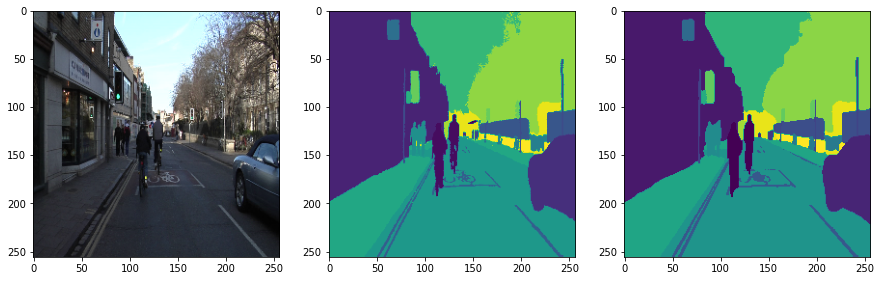

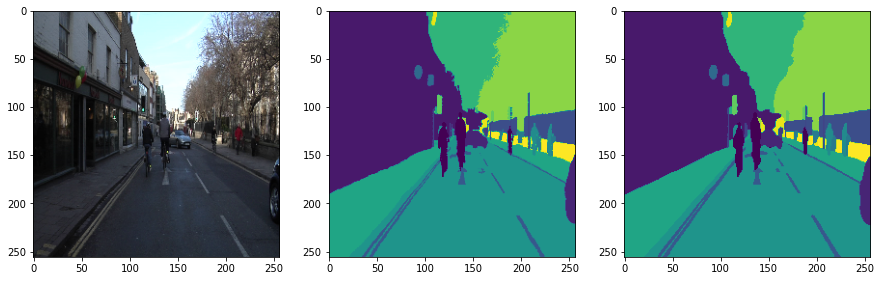

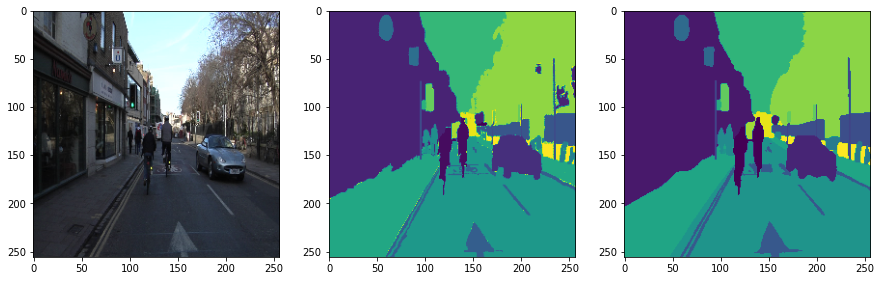

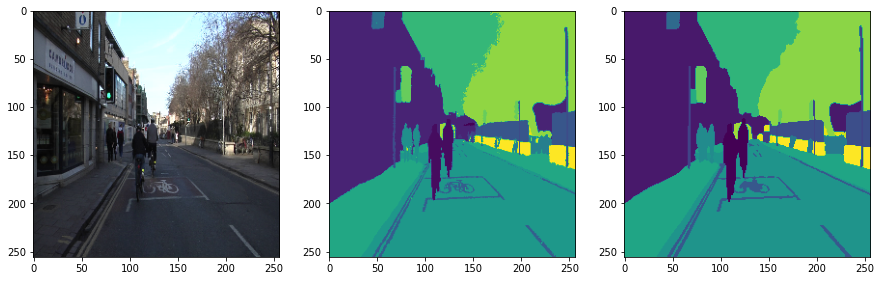

In [247]:
batch = next(iter(train_dataloader))

pl_model.eval()

with torch.no_grad():
  x,y = batch
  logits, _ = pl_model(x.cuda())
  preds = torch.argmax(logits, dim=1)

images, labels = batch

#Código de demonstração dos resultados do Orllem enquanto testo os resultados
for image, label, pred in zip(images, labels, preds):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
  ax1.imshow(image.permute(1,2,0).numpy())
  ax2.imshow(label.squeeze())
  ax3.imshow(pred.cpu().squeeze())
  plt.show() 

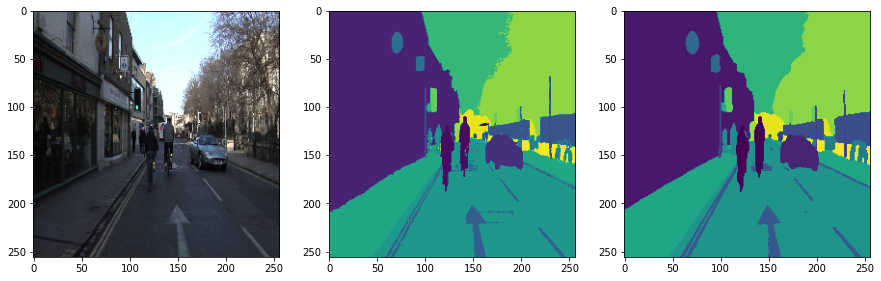

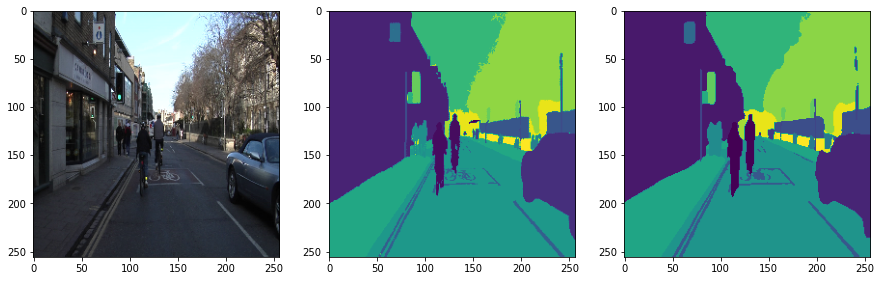

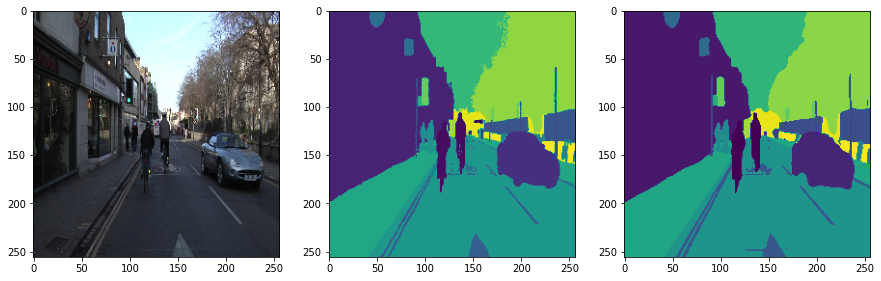

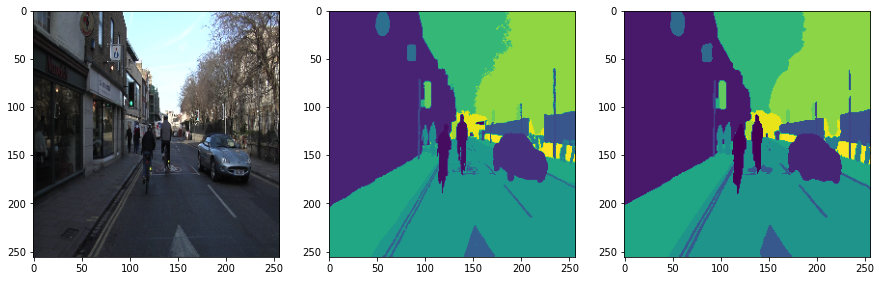

In [248]:
batch = next(iter(val_dataloader))

pl_model.eval()

with torch.no_grad():
  x,y = batch
  logits, _ = pl_model(x.cuda())
  preds = torch.argmax(logits, dim=1)

images, labels = batch

for image, label, pred in zip(images, labels, preds):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
  ax1.imshow(image.permute(1,2,0).numpy())
  ax2.imshow(label.squeeze())
  ax3.imshow(pred.cpu().squeeze())
  plt.show() 

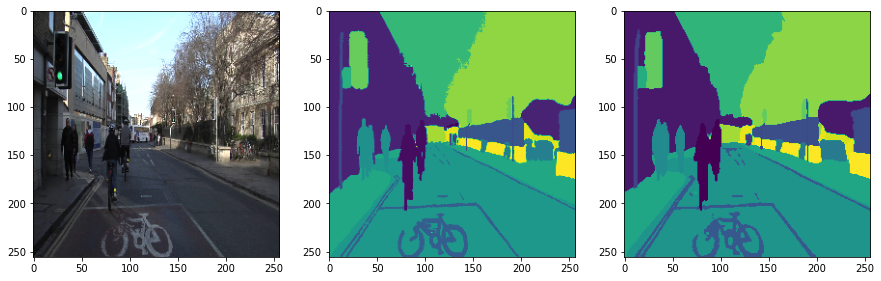

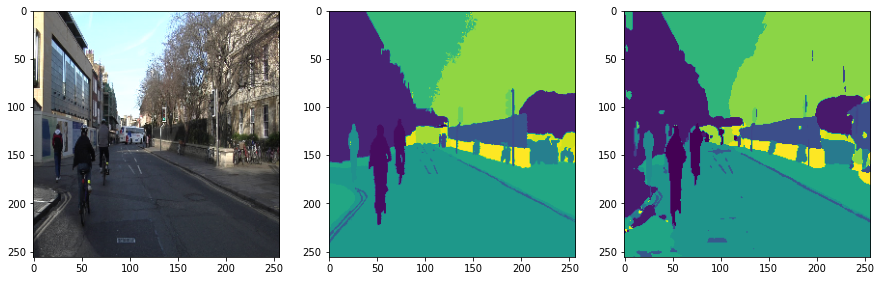

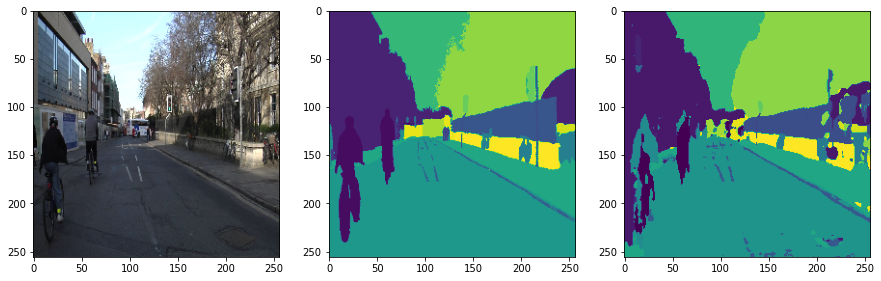

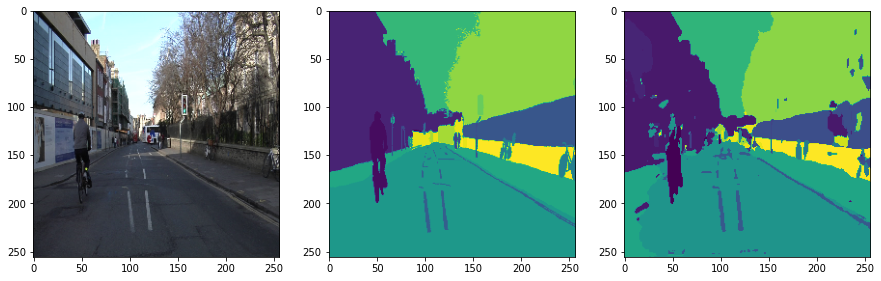

In [249]:
batch = next(iter(test_dataloader))

pl_model.eval()

with torch.no_grad():
  x,y = batch
  logits, _ = pl_model(x.cuda())
  preds = torch.argmax(logits, dim=1)

images, labels = batch

for image, label, pred in zip(images, labels, preds):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
  ax1.imshow(image.permute(1,2,0).numpy())
  ax2.imshow(label.squeeze())
  ax3.imshow(pred.cpu().squeeze())
  plt.show() 